# Planetary Data Analysis Notebook

For the first part of this script, I will solely focus on the kNN supervised learning technique applied to the data pertaining to exoplanets from NASA.

In [1]:
# Import necessary libraries
from random import seed
from random import randrange
from numpy.random import rand
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats
from math import sqrt
from scipy.stats import wilcoxon
from scipy.stats import spearmanr

In [2]:
# Assign path of data to a variable.
# Initiate first data frame with raw data.
seed(11)
path = 'https://raw.githubusercontent.com/jbravo87/blog-projects/main/data/PS_2022.05.10_21.48.38.csv'
raw_data = pd.read_csv(path, skiprows = 12)

Need to remove the first twelve rows. These rows contain copious notes/remarks. Want to see the head and tail of the data as well as the column names.

In [3]:
raw_data

,pl_name,hostname,pl_orbper,pl_bmassj,pl_orbeccen,pl_eqt
0,11 Com b,11 Com,326.03000,19.40,0.231,NaN
1,11 Com b,11 Com,NaN,17.10,NaN,NaN
2,11 UMi b,11 UMi,NaN,10.80,NaN,NaN
3,11 UMi b,11 UMi,516.21997,14.74,0.080,NaN
4,11 UMi b,11 UMi,516.22000,10.50,0.080,NaN
...,...,...,...,...,...,...
32511,ups And d,ups And,1282.41000,4.10,0.294,NaN
32512,ups And d,ups And,1281.50700,10.25,0.316,NaN
32513,ups Leo b,ups Leo,385.20000,0.51,0.320,NaN
32514,xi Aql b,xi Aql,NaN,2.02,NaN,NaN


In [4]:
raw_data.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_bmassj', 'pl_orbeccen',
       'pl_eqt'],
      dtype='object')

Now want to create first data frame with columns of interest. In this first case/scenario want to study planet eccentricity (dependent/response variable) as a function of orbital period of planet (independent/predictor variable).

## Case 1 - Eccentricity as function of Orbital Period

In [5]:
df1 = raw_data.loc[:, ['pl_name','pl_orbper','pl_orbeccen']]
#df1.reset_index(drop=True, inplace=True) # <- Perhaps use this logic in a couple of lines.
df1

,pl_name,pl_orbper,pl_orbeccen
0,11 Com b,326.03000,0.231
1,11 Com b,NaN,NaN
2,11 UMi b,NaN,NaN
3,11 UMi b,516.21997,0.080
4,11 UMi b,516.22000,0.080
...,...,...,...
32511,ups And d,1282.41000,0.294
32512,ups And d,1281.50700,0.316
32513,ups Leo b,385.20000,0.320
32514,xi Aql b,NaN,NaN


Will rename the columns of interest for ease, i.e. make analysis clearer, and remove unnecessary rows by removing all the NA values from the original data frame.

In [6]:
df1 = df1.rename(columns={'pl_name':'planetname', 'pl_orbper':'orbitperiod', 'pl_orbeccen':'eccentricity'})
df1 = df1.dropna()
df1

,planetname,orbitperiod,eccentricity
0,11 Com b,326.03000,0.2310
3,11 UMi b,516.21997,0.0800
4,11 UMi b,516.22000,0.0800
6,14 And b,185.84000,0.0000
7,14 Her b,1766.41000,0.3674
...,...,...,...
32510,ups And d,1274.60000,0.2420
32511,ups And d,1282.41000,0.2940
32512,ups And d,1281.50700,0.3160
32513,ups Leo b,385.20000,0.3200


The following logic is to determine the data types of the column entries in the latest data frame. Again, this is the data type (dtype) for individual entries within the data frame.

In [7]:
print(type(df1.iloc[0][1]))
print(type(df1.iloc[0][2]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [8]:
type(df1)

pandas.core.frame.DataFrame

In [9]:
print("The data type of the eccentricity column is:", df1.dtypes['eccentricity'])

The data type of the eccentricity column is: float64


Notice df1 is indeed a data frame, and the entries within are numpy float number type.

Want to limit each scenario to two dataframes. Once cleaned, need another to take arithmetic mean of multiple entries. For example, Dataframe 2 will take the averages of multiple planet entries. Following lines will take arithmetic mean of the two columns of interest and concate the two columns into the third dataframe.

First will create intermediate variables to store the resulting averages.

In [10]:
eccen = df1.groupby('planetname')['eccentricity'].mean()
orbper = df1.groupby('planetname')['orbitperiod'].mean()

In [11]:
print(eccen)
print(orbper)

planetname
11 Com b      0.231000
11 UMi b      0.080000
14 And b      0.000000
14 Her b      0.362233
16 Cyg B b    0.676033
                ...   
ups And b     0.030200
ups And c     0.238933
ups And d     0.281117
ups Leo b     0.320000
xi Aql b      0.000000
Name: eccentricity, Length: 4371, dtype: float64
planetname
11 Com b       326.030000
11 UMi b       516.219985
14 And b       185.840000
14 Her b      1766.601670
16 Cyg B b     799.375000
                 ...     
ups And b        4.616229
ups And c      240.728533
ups And d     1285.346167
ups Leo b      385.200000
xi Aql b       136.750000
Name: orbitperiod, Length: 4371, dtype: float64


In [12]:
type(eccen)

pandas.core.series.Series

In [13]:
type(orbper)

pandas.core.series.Series

In this part want to explicitly declare the median and IQR of the two columns which are the variables. But the summary statistics part of the analysis can be done with variables declared earlier.

In [14]:
eccen_med = statistics.median(list(eccen))
orbper_med = statistics.median(list(orbper))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the eccentricity: %.2f' % eccen_med)
iqr_eccen = stats.iqr(eccen, interpolation = 'midpoint')
iqr_orbper = stats.iqr(orbper, interpolation = 'midpoint')
print('\nThe interquartile range of the eccentricity: %.2f' % iqr_eccen)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_orbper)
#eccen_mode = statistics.mode(list(eccen))
#print('\nThe mode for the eccentricity: %.2f' % eccen_mode)
#orbper_mode = statistics.mode(list(orbper))
#print('\nThe mode for the orbital period: %.2f' % orbper_mode)
eccen_avg = statistics.mean(list(eccen))
print('\nThe mean for the eccentricity: %.2f' % eccen_avg)
orbper_avg = statistics.mean(list(orbper))
print('\nThe mean for the orbital period: %.2f' % orbper_avg)


The median of the orbital period: 12.2538

The median of the eccentricity: 0.00

The interquartile range of the eccentricity: 0.07

The interquartile range of the orbital period: 39.93

The mean for the eccentricity: 0.06

The mean for the orbital period: 709.51


Five number summary including the central tendencies above.

In [15]:
def fivenum(data):
    """Five-number summary."""
    return np.percentile(data, [0, 25, 50, 75, 100], interpolation = 'midpoint')

In [16]:
# Min, 1st quantile, median, 3rd quantile, max
fivenum(eccen)

C:\Users\joepb\AppData\Local\Temp\ipykernel_10548\3996052072.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(data, [0, 25, 50, 75, 100], interpolation = 'midpoint')


array([0.        , 0.        , 0.        , 0.0659375 , 0.93188167])

In [17]:
# Min, 1st quantile, median, 3rd quantile, max
fivenum(orbper)

C:\Users\joepb\AppData\Local\Temp\ipykernel_10548\3996052072.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(data, [0, 25, 50, 75, 100], interpolation = 'midpoint')


array([9.07062900e-02, 4.60227484e+00, 1.22538359e+01, 4.45284631e+01,
       1.79000000e+06])

In [18]:
df1 = pd.concat([orbper, eccen], axis = 1)
df1

,orbitperiod,eccentricity
planetname,,
11 Com b,326.030000,0.231000
11 UMi b,516.219985,0.080000
14 And b,185.840000,0.000000
14 Her b,1766.601670,0.362233
16 Cyg B b,799.375000,0.676033
...,...,...
ups And b,4.616229,0.030200
ups And c,240.728533,0.238933
ups And d,1285.346167,0.281117


All the filtering and cleaning was handled by end of df1.

In [19]:
df1.columns

Index(['orbitperiod', 'eccentricity'], dtype='object')

The orbital period is skewed right, but after applying a log transform, the distribution more closely resembles a Gaussian distribution.

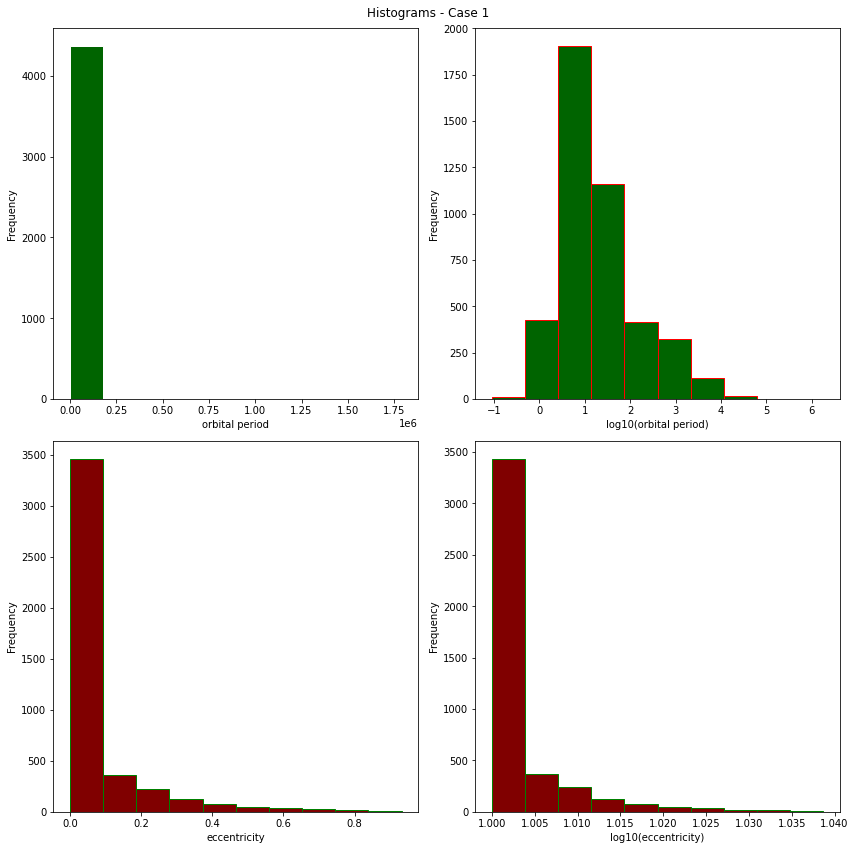

In [20]:
# First, perform log base 10 transform
orbper_log = np.log10(orbper)
eccen_log = np.log10(eccen + 10)
# Plotting Logic
fig1, ax1 = plt.subplots(2, 2,figsize = (12, 12))
fig1.suptitle('Histograms - Case 1')
ax1[0, 0].hist(orbper, color = 'darkgreen', edgecolor = 'white')
#ax1[0, 0].set_title('') #<- use this logic to give each plot its own title.
ax1[0, 0].set(xlabel = 'orbital period')
ax1[0, 1].hist(orbper_log, color = "darkgreen", edgecolor = 'red')
ax1[0, 1].set(xlabel = 'log10(orbital period)')
ax1[1, 0].hist(eccen, color = "maroon", edgecolor = 'green')
ax1[1, 0].set(xlabel = 'eccentricity')
ax1[1, 1].hist(eccen_log, color = "maroon", edgecolor = 'green')
ax1[1, 1].set(xlabel = 'log10(eccentricity)')

for ax in ax1.flat:
    ax.set(ylabel = 'Frequency')
plt.savefig('histograms_1.png')
fig1.tight_layout()

The distribution is still skewed right after applying the transform.

#### Model Building

As a resampling method, will use the train-test-split (tts) method.

In [21]:
X1 = np.array(orbper).reshape(-1,1)
y1 = np.array(eccen).reshape(-1, 1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size = 0.80, random_state = 25)
y1_train = y1_train.reshape(len(y1_train), )
y1_test = y1_test.reshape(len(y1_test), )

Will change the central tendency metric from median to mean to get a better R-squared metric.

In [22]:
# For central tendency can use either median or mean.
y_baseline = y1_train.mean()
#y_baseline = statistics.median(y1_train)
y_baseline

0.0637315305801972

In [23]:
y_pred_train = [y_baseline] * len(y1_train)

In [24]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_1 = mean_absolute_error(y1_train, y_pred_train)
print(f'Traing Set Mean Absolute Error: {mae_train_1}')
# Mean squared error for training data baseline guess.
mse_train_1 = mean_squared_error(y1_train, y_pred_train)
print(f'Traing Set Mean Squared Error: {mse_train_1}')
rmse_train_1 = sqrt(mse_train_1) # <- will compute the root mean square error
print(f'Traing Set Root Mean Square Error: {rmse_train_1}')
# R-squared for training data baseline guess.
r2_train_1 = r2_score(y1_train, y_pred_train)
print(f'Traing Set R2: {r2_train_1}')

Traing Set Mean Absolute Error: 0.08752901986553943
Traing Set Mean Squared Error: 0.01788375152612843
Traing Set Root Mean Square Error: 0.13373014441825906
Traing Set R2: 0.0


In [25]:
y_pred_test = [y_baseline] * len(y1_test)

In [26]:
# Error for test data baseline guess.
mae_test_1 = mean_absolute_error(y1_test, y_pred_test)
print(f'Test Set Mean Absolute Error: {mae_test_1}')
# Mean squared error for test data baseline guess.
mse_test_1 = mean_squared_error(y1_test, y_pred_test)
print(f'Test Set Mean Squared Error: {mse_test_1}')
rmse_test_1 = sqrt(mse_test_1) # <- will compute the root mean square error
print(f'Test Set Root Mean Square Error: {rmse_test_1}')
# R-squared for test data baseline guess.
r2_test_1 = r2_score(y1_test, y_pred_test)
print(f'Test Set R2: {r2_test_1}')

Test Set Mean Absolute Error: 0.09067568318514926
Test Set Mean Squared Error: 0.019771780663498325
Test Set Root Mean Square Error: 0.14061216399550333
Test Set R2: -9.981601752739877e-05


In [27]:
prediction_1 = pd.DataFrame(['Baseline', mae_train_1, mse_train_1, rmse_train_1, r2_train_1, mae_test_1, mse_test_1, rmse_test_1, r2_test_1]).T
metric_col_names = ['Method', 'Train MAE', 'Train MSE', 'Train RMSE', 'Train R2', 'Test MAE', 'Test MSE','Test RMSE', 'Test R2'] # <- This list will be used over so easier to store in variable.
prediction_1.columns = metric_col_names
prediction_1

,Method,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Baseline,0.087529,0.017884,0.13373,0.0,0.090676,0.019772,0.140612,-0.0001


Now to apply the logarithmic and exponential transformations to the variables I chose.

In [28]:
X1_train_log = np.log10(X1_train)
X1_test_log = np.log10(X1_test)
#y1_train_log = np.log(y1_train + 10) # <- Remember to add 10 units to be able apply log transform
y1_train_exp = np.exp(y1_train)
y1_test_exp = np.exp(y1_test)

With the data scaled using aforementioned trasnformations, will now test various k's for best fit. Will run kNN for various values of n_neighbors and store results. This will help me determine optimal 'k'.

In [29]:
# kNN R-squared accuracy for 1st kNN model
knn_r_acc_1 = []
for i1 in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i1)
    knn.fit(X1_train_log.reshape(-1, 1), y1_train_exp.reshape(-1, 1))
    test_score_1 = knn.score(X1_test_log.reshape(-1, 1), y1_test_exp.reshape(-1, 1))
    train_score_1 = knn.score(X1_train_log.reshape(-1, 1), y1_train_exp.reshape(-1, 1))
    knn_r_acc_1.append((i1, test_score_1, train_score_1))
outcomes_1 = pd.DataFrame(knn_r_acc_1, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_1)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_1.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_1.loc[outcomes_1['Test Score'] == outcomes_1.iloc[:,1].max(), 'k'].iloc[0])

     k  Test Score  Train Score
0    1   -0.412030     0.999952
1    2   -0.034727     0.658756
2    3    0.063430     0.523690
3    4    0.113859     0.464703
4    5    0.152989     0.429283
..  ..         ...          ...
69  70    0.328161     0.293869
70  71    0.326611     0.293246
71  72    0.325548     0.292819
72  73    0.325778     0.292287
73  74    0.325112     0.292808

[74 rows x 3 columns]
The highest Test R-squared value occurs at : 0.3282
Within given range, optimal k is:  70


Bootstrap confidence interval to get estimate on RMSE for various models.

In [30]:
def ci_bootstrap(df, model):
    # set up data
    values = df.values
    # configure bootstrap
    n_iters = 1000
    n_size = 500
    metrics = []
    # for loop
    for index in range(n_iters):
        # prep training and testing sets
        train = resample(values, n_samples = n_size)
        test = np.array([i for i in values if i.tolist() not in train.tolist()])
        # Fit model
        model.fit(train[:,:-1], train[:,-1])
        # Evaluate model
        predictions = model.predict(test[:,:-1])
        score = np.sqrt(mean_squared_error(test[:,-1], predictions))
        #print(score)
        metrics.append(score)
    metrics = pd.Series(metrics)
    return metrics

In [ ]:
import time
startTime = time.time()

df2 = pd.concat([np.log10(orbper), eccen], axis=1)
metrics1_1 = ci_bootstrap(df2, KNeighborsRegressor(n_neighbors = 64))

# Plotting Logic
fig1_2, ax1_2 = plt.subplots(3,1,figsize = (11, 12))
#fig1_2.suptitle('Bootstrap Performance Metrics - Case 1')

# Confidence Interval
confidence_interval1_1 = list(metrics1_1.quantile([0.025, 0.975]))

ax1_2[0].hist(metrics1_1, color='#4db32e', edgecolor = "red")
ax1_2[0].plot(confidence_interval1_1, [190, 190], color='black')
for x1 in confidence_interval1_1:
    ax1_2[0].plot([x1, x1], [0, 200], color='black')
    ax1_2[0].text(x1, 210, f'{x1:.4f}', 
            horizontalalignment='center', verticalalignment='center')
ax1_2[0].text(sum(confidence_interval1_1) / 2, 60, '95% interval',
        horizontalalignment='center', verticalalignment='center')

mean_knn_model_1 = metrics1_1.mean()
ax1_2[0].plot([mean_knn_model_1, mean_knn_model_1], [0, 195], color='black', linestyle='--')
ax1_2[0].text(mean_knn_model_1, 225, f'Mean: {mean_knn_model_1:.4f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax1_2[0].set_title('kNN Model 1')

# Now for the SVR model
eps_1 = 8 #<- hyperparameters used throughout the script
hyperparam1 = 1000 #<- hyperparameters used throughout the script
metrics1_2 = ci_bootstrap(df2, SVR(kernel = 'rbf', C = hyperparam1, epsilon = eps_1))
confidence_interval1_2 = list(metrics1_2.quantile([0.025, 0.975]))

ax1_2[1].hist(metrics1_2, color='#7961c9', edgecolor = "red")
ax1_2[1].plot(confidence_interval1_2, [190, 190], color='black')
for x1 in confidence_interval1_2:
    ax1_2[1].plot([x1, x1], [0, 200], color='black')
    ax1_2[1].text(x1, 210, f'{x1:.4f}', 
            horizontalalignment='center', verticalalignment='center')
ax1_2[1].text(sum(confidence_interval1_2) / 2, 60, '95% interval',
        horizontalalignment='center', verticalalignment='center')

mean_svr_model_1 = metrics1_2.mean()
ax1_2[1].plot([mean_svr_model_1, mean_svr_model_1], [0, 195], color='black', linestyle='--')
ax1_2[1].text(mean_svr_model_1, 225, f'Mean: {mean_svr_model_1:.4f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax1_2[1].set_title('SVR Model 1')

# Now for the Random Forest model
metrics1_3 = ci_bootstrap(df2, RandomForestRegressor(max_depth=2))
confidence_interval1_3 = list(metrics1_3.quantile([0.025, 0.975]))

ax1_2[2].hist(metrics1_3, color='#03dffc', edgecolor = "black")
ax1_2[2].plot(confidence_interval1_3, [190, 190], color='black')
for x1 in confidence_interval1_3:
    ax1_2[2].plot([x1, x1], [0, 200], color='black')
    ax1_2[2].text(x1, 210, f'{x1:.4f}', 
            horizontalalignment='center', verticalalignment='center')
ax1_2[2].text(sum(confidence_interval1_3) / 2, 60, '95% interval',
        horizontalalignment='center', verticalalignment='center')

mean_rf_model_1 = metrics1_3.mean()
ax1_2[2].plot([mean_rf_model_1, mean_rf_model_1], [0, 195], color='black', linestyle='--')
ax1_2[2].text(mean_rf_model_1, 225, f'Mean: {mean_rf_model_1:.4f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax1_2[2].set_title('RF Model 1')

for ax in ax1_2.flat:
    ax.set(ylabel = 'Counts')
    #ax.set(xlabel = 'RMSE eccentricity (unitless)')
    
plt.savefig('bootstrap_rmse_1.png')

fig1_2.tight_layout()

#plt.tight_layout()

#plt.title('Confidence Interval')

#plt.show()

executionTime = (time.time() - startTime)
print('Execution time in minutes: ' + str(executionTime/60))

In [ ]:
#metrics1_1.mean()
len(metrics1_1)

In [ ]:
knn_model_1 = KNeighborsRegressor(n_neighbors = 64)
knn_model_1.fit(X1_train_log, y1_train)
y_knn_train_pred_log_1 = knn_model_1.predict(X1_train_log)
y_knn_test_pred_log_1 = knn_model_1.predict(X1_test_log)

In [ ]:
# Following line to remind myself that values between 0 - 1 will produce negative value in log.
np.log(0.055550)

In [ ]:
# Following logic 
#y_knn_train_pred_1 = np.exp(y_knn_train_pred_log_1)
#y_knn_train_pred_1 = np.power(y_knn_train_pred_log_1, 10)
y_knn_train_pred_1 = y_knn_train_pred_log_1
#y_knn_test_pred_1 = np.log(y_knn_test_pred_log_1) 
#y_knn_test_pred_1 = np.power(y_knn_test_pred_log_1, 10)
y_knn_test_pred_1 = y_knn_test_pred_log_1
#y_knn_test_pred_1 = np.exp(y_knn_test_pred_log_1) 

Trying to avoid data leakage when going from transform to inverse.

In [ ]:
# First the training metrics.
knn1_train_mae = mean_absolute_error(y1_train, y_knn_train_pred_1)
knn1_train_mse = mean_squared_error(y1_train, y_knn_train_pred_1)
knn1_train_rmse = sqrt(knn1_train_mse) # <- will compute the root mean square error
knn1_train_r2 = r2_score(y1_train, y_knn_train_pred_1)
# Now, test set metrics.
knn1_test_mae = mean_absolute_error(y1_test, y_knn_test_pred_1)
knn1_test_mse = mean_squared_error(y1_test, y_knn_test_pred_1)
knn1_test_rmse = sqrt(knn1_test_mse)
knn1_test_r2 = r2_score(y1_test, y_knn_test_pred_1)
# Consolidate the results.
knn_results_1 = pd.DataFrame(['k Nearest Neighbor', knn1_train_mae, knn1_train_mse, knn1_train_rmse, knn1_train_r2, knn1_test_mae, knn1_test_mse, knn1_test_rmse, knn1_test_r2]).transpose()
knn_results_1.columns = metric_col_names
knn_results_1

#### SVR regressor model.

In [ ]:
eps_1 = 8
hyperparam1 = 1000
svr_model_1 = SVR(kernel = 'rbf', C = hyperparam1, epsilon = eps_1)
svr_model_1.fit(X1_train_log, y1_train)
y_svr_train_pred_1 = svr_model_1.predict(X1_train_log)
y_svr_test_pred_1 = svr_model_1.predict(X1_test_log)
# Model performance - training set
svr1_train_mae = mean_absolute_error(y1_train, y_svr_train_pred_1)
svr1_train_mse = mean_squared_error(y1_train, y_svr_train_pred_1)
svr1_train_rmse = sqrt(svr1_train_mse)
svr1_train_r2 = r2_score(y1_train, y_svr_train_pred_1)
# Test results
svr1_test_mae = mean_absolute_error(y1_test, y_svr_test_pred_1)
svr1_test_mse = mean_squared_error(y1_test, y_svr_test_pred_1)
svr1_test_rmse = sqrt(svr1_test_mse)
svr1_test_r2 = r2_score(X1_test, y_svr_test_pred_1)
# Consolidate the results.
svr_results_1 = pd.DataFrame(['SVR', svr1_train_mae, svr1_train_mse, svr1_train_rmse, svr1_train_r2, svr1_test_mae, svr1_test_mse, svr1_test_rmse, svr1_test_r2]).T
svr_results_1.columns = metric_col_names
svr_results_1

Now want to model using the Random Forest Regressor.

In [ ]:
rf_1 = RandomForestRegressor(max_depth=2)
#rf_1.fit(X1_train_log.reshape(-1, 1), y1_train.reshape(-1, 1))
rf_1.fit(X1_train_log, y1_train)
#y_rf_train_pred_1 = rf_1.predict(X1_train_log.reshape(-1, 1))
y_rf_train_pred_1 = rf_1.predict(X1_train_log)
#y_rf_test_pred_1 = rf_1.predict(X1_test_log.reshape(-1, 1))
y_rf_test_pred_1 = rf_1.predict(X1_test_log)
rf_1

In [ ]:
# Model performance metrics for random forest model.
rf1_train_mae = mean_absolute_error(y1_train, y_rf_train_pred_1)
rf1_train_mse = mean_squared_error(y1_train, y_rf_train_pred_1)
rf1_train_rmse = sqrt(rf1_train_mse)
rf1_train_r2 = r2_score(y1_train, y_rf_train_pred_1)
# The following are the test metrics.
rf1_test_mae = mean_absolute_error(y1_test, y_rf_test_pred_1)
rf1_test_mse = mean_squared_error(y1_test, y_rf_test_pred_1)
rf1_test_rmse = sqrt(rf1_test_mse)
rf1_test_r2 = r2_score(y1_test, y_rf_test_pred_1)

In [ ]:
rf1_results = pd.DataFrame(['Random Forest', rf1_train_mae, rf1_train_mse, rf1_train_rmse, rf1_train_r2, rf1_test_mae, rf1_test_mse, rf1_test_rmse, rf1_test_r2]).transpose()
rf1_results.columns = metric_col_names
rf1_results

Want to add all the results to a single table.

In [ ]:
results_1 = pd.concat([prediction_1, knn_results_1, svr_results_1, rf1_results], axis = 0, ignore_index = True)
results_1 

### Bootstrap Confidence Intervals

For this section, want to develop logic to use bootstrap method to configure confidence interval.

In [ ]:
df2_log = pd.concat([np.log10(orbper), eccen], axis = 1)
df2_log

In [ ]:
df2_log.values

In [ ]:
type(df2_log)

In [ ]:
#plt.hist(a1, color = '#4db32e', edgecolor = 'red') #<- Good color scheme
#plt.hist(a2, color = '#ad6dcf', edgecolor = 'white')

### Plotting Case 1

Want to make a quick calculation of the residuals in this prediction and actual values evaluation.

In [ ]:
true_values_1 = y1_test
predicted_values1_1 = y_knn_test_pred_1
predicted_values1_2 = y_svr_test_pred_1
predicted_values1_3 = y_rf_test_pred_1
plt.figure(figsize = (10, 10))
# kNN model
knn_1 = plt.scatter(x = true_values_1, y = predicted_values1_1, c = '#d68431')
# SVR model
svr_1 = plt.scatter(x = true_values_1, y = predicted_values1_2, c = 'lime', marker = 'x')
# Random Forest model
rf_1 = plt.scatter(x = true_values_1, y = predicted_values1_3, c = '#b337cc', marker = 'd')
p1 = max(max(predicted_values1_1), max(predicted_values1_2), max(predicted_values1_3), max(true_values_1))
p2 = min(min(predicted_values1_1), min(predicted_values1_2), min(predicted_values1_3), min(true_values_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Prediction and Actual Values')
plt.xlabel('Actual Eccentricity Values')
plt.ylabel('Predicted Eccentricity Values')
plt.legend([knn_1, svr_1, rf_1], ['kNN', 'SVR', 'RF'], loc = 'upper left')
plt.savefig('pred_vs_actual_1.png')
plt.show()

Want to plot the residuals and see if there are any obvious patterns. Another name is the Versus Fit.

In [ ]:
# Will invoke for loop to calculate residulas for the three different models.
residuals1_1 = list()
for item1, item2 in zip(true_values_1, predicted_values1_1):
    residuals1_1.append(item1 - item2)
residuals1_2 = list()
for item3, item4 in zip(true_values_1, predicted_values1_2):
    residuals1_2.append(item3 - item4)
residuals1_3 = list()
for item5, item6 in zip(true_values_1, predicted_values1_3):
    residuals1_3.append(item5 - item6)

plt.figure(figsize = (9, 9))
# kNN model
knn_resid_1 = plt.scatter(x = predicted_values1_1, y = residuals1_1, c = '#d68431')
# SVR model
svr_resid_1 = plt.scatter(x = predicted_values1_2, y = residuals1_2, c = 'lime', marker = 'x')
# Random Forest model
rf_resid_1 = plt.scatter(x = predicted_values1_3, y = residuals1_3, c = '#b337cc', marker = 'd')

plt.title('Residuals versus Fitted values')
plt.xlabel('Fitted Values') # <- Predicted Values
plt.ylabel('Residuals')
plt.legend([knn_resid_1, svr_resid_1, rf_resid_1], ['kNN', 'SVR', 'RF'], loc = 'upper right')
plt.axhline(y = 0.0, color = '#034b8a', linestyle = '--')
plt.savefig('output_2.png')
plt.show()

There is an obvious pattern in the residuals plot.

In [ ]:
plt.hist(residuals1_2, color = "teal", edgecolor = 'white')

### Scenario 2 - temperature as function of planet mass

Now want to begin analysis of equilibrium temperature as a function of planet size.

In [ ]:
df3 = raw_data.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df3

In [ ]:
df3 = df3.rename(columns={'pl_name':'planetname', 'pl_bmassj':'mass', 'pl_eqt':'temperature'})
df3 = df3.dropna()
df3

In [ ]:
mass = df3.groupby('planetname')['mass'].mean()
temp = df3.groupby('planetname')['temperature'].mean()

In [ ]:
print(mass)
print(temp)

Want some summary statistics for the new two variables.

In [ ]:
mass_med = statistics.median(list(mass))
temp_med = statistics.median(list(temp))
print('\nThe median mass: %.4f' % mass_med)
print('\nThe median temperature: %.2f' % temp_med)
iqr_mass = stats.iqr(mass, interpolation = 'midpoint')
iqr_temp = stats.iqr(temp, interpolation = 'midpoint')
print('\nThe interquartile range of the mass: %.2f' % iqr_mass)
print('\nThe interquartile range of the temperature: %.2f' % iqr_temp)
mass_mode = statistics.mode(list(mass))
print('\nThe mode for the mass: %.2f' % mass_mode)
temp_mode = statistics.mode(list(temp))
print('\nThe mode for the temperature: %.2f' % temp_mode)
mass_avg = statistics.mean(list(mass))
print('\nThe mean for the mass: %.2f' % mass_avg)
temp_avg = statistics.mean(list(temp))
print('\nThe mean for the planetary temperature: %.2f' % temp_avg)

In [ ]:
# First, perform log base 10 transform
mass_log = np.log10(mass)
temp_log = np.log10(temp)
# Plotting Logic
fig2, ax2 = plt.subplots(2, 2,figsize = (12, 12))
fig2.suptitle('Histograms - Case 2')
ax2[0, 0].hist(mass, color = 'blueviolet', edgecolor = 'white')
#ax2[0, 0].set_title('') #<- use this logic to give each plot its own title.
ax2[0, 0].set(xlabel = 'planet mass (Jupiter mass)')
ax2[0, 1].hist(mass_log, color = 'blueviolet', edgecolor = 'red')
ax2[0, 1].set(xlabel = 'log10(planet mass)')
ax2[1, 0].hist(temp, color = 'teal', edgecolor = 'white')
ax2[1, 0].set(xlabel = 'equilibrium temperature')
ax2[1, 1].hist(temp_log, color = 'teal', edgecolor = 'red')
ax2[1, 1].set(xlabel = 'log10(equilibrium temperature)')

for ax in ax1.flat:
    ax.set(ylabel = 'Frequency')
plt.savefig('histograms_2.png')
fig1.tight_layout()

The distribution became more normally distributed when applying the log base 10 transformation on the dataset.

In this case, the dataset became skew left when the logarithmic transformation was applied.

Will now split the data into their respective sets.

In [ ]:
X2 = np.array(mass).reshape(-1,1)
y2 = np.array(temp).reshape(-1, 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.80, random_state = 25)
y2_train = y2_train.reshape(len(y2_train), )
y2_test = y2_test.reshape(len(y2_test), )

In [ ]:
# Establishing baselines for predictions according to the y-variable or response variable.
y_baseline_2= y2_train.mean()
#y_baseline_2= statistics.median(y2_train)
y_pred_train_2 = [y_baseline_2]*len(y2_train) #<- Training Baseline
y_pred_test_2 = [y_baseline_2]*len(y2_test)

In [ ]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_2 = mean_absolute_error(y2_train, y_pred_train_2)
# Mean squared error for training data baseline guess.
mse_train_2 = mean_squared_error(y2_train, y_pred_train_2)
rmse_train_2 = sqrt(mse_train_2) # <- will compute the root mean square error
# R-squared for training data baseline guess.
y2_train_r2 = r2_score(y2_train, y_pred_train_2)

In [ ]:
# Error for test data baseline guess.
mae_test_2 = mean_absolute_error(y2_test, y_pred_test_2)
# Mean squared error for test data baseline guess.
mse_test_2 = mean_squared_error(y2_test, y_pred_test_2)
# Test Root Mean Square Error
rmse_test_2 = sqrt(mse_test_2)
# R-squared for test data baseline guess.
y2_test_r2 = r2_score(y2_test, y_pred_test_2)

In [ ]:
baseline_2 = pd.DataFrame(['Baseline', mae_train_2, mse_train_2, rmse_train_2, y2_train_r2, mae_test_2, mse_test_2, rmse_test_2, y2_test_r2]).T
baseline_2.columns = metric_col_names
baseline_2

Recall that the response variable (y) in this case is the mass of the planet (in Jupiter masses) which needs the log base 10 transform.

In [ ]:
X2_train_log, X2_test_log = np.log10(X2_train), np.log10(X2_test)
y2_train_log = np.log10(y2_train)

In [ ]:
# kNN R-squared accuracy
knn_r_acc_2 = []
for j in range(1, 75, 1):
    knn_2 = KNeighborsRegressor(n_neighbors = j)
    knn_2.fit(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
    test_score_2 = knn_2.score(X2_test_log.reshape(-1, 1), np.log10(y2_test))
    train_score_2 = knn_2.score(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
    knn_r_acc_2.append((j, test_score_2, train_score_2))
outcomes_2 = pd.DataFrame(knn_r_acc_2, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_2)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_2.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_2.loc[outcomes_2['Test Score'] == outcomes_2.iloc[:,1].max(), 'k'].iloc[0])

In [ ]:
model_knn_2 = KNeighborsRegressor(n_neighbors = 40)
model_knn_2.fit(X2_train_log.reshape(-1, 1), y2_train_log.reshape(-1, 1))
y_knn_train_pred_2_log = model_knn_2.predict(X2_train_log.reshape(-1, 1))
y_knn_test_pred_2_log = model_knn_2.predict(X2_test_log.reshape(-1, 1))

In [ ]:
y_knn_train_pred_2 = pow(10, y_knn_train_pred_2_log)
#y_knn_train_pred_2 = y_knn_train_pred_2_log
y_knn_test_pred_2 = pow(10, y_knn_test_pred_2_log)
#y_knn_test_pred_2 = y_knn_test_pred_2_log
#X2_inverse = pow(10, y_knn_test_pred_2_log) #<- Will cause runtime error that is overflow in power function.

In [ ]:
# First the training metrics.
knn2_train_mae = mean_absolute_error(y2_train, y_knn_train_pred_2)
knn2_train_mse = mean_squared_error(y2_train, y_knn_train_pred_2)
knn2_train_rmse = sqrt(knn2_train_mse) # <- will compute the root mean square error
knn2_train_r2 = r2_score(y2_train, y_knn_train_pred_2)
# Now, test set metrics.
knn2_test_mae = mean_absolute_error(y2_test, y_knn_test_pred_2)
knn2_test_mse = mean_squared_error(y2_test, y_knn_test_pred_2)
knn2_test_rmse = sqrt(knn2_test_mse)
knn2_test_r2 = r2_score(y2_test, y_knn_test_pred_2)
# Consolidate the results.
knn_results_2 = pd.DataFrame(['k Nearest Neighbor', knn2_train_mae, knn2_train_mse, knn2_train_rmse, knn2_train_r2, knn2_test_mae, knn2_test_mse, knn2_test_rmse, knn2_test_r2]).transpose()
knn_results_2.columns = metric_col_names
knn_results_2

Now to build Support Vector Regressor model.

In [ ]:
# Setting the hyperparameter
eps = 8
hyperparam1 = 1000
svr_2 = SVR(kernel = 'rbf', C = hyperparam1, epsilon = eps)
svr_2.fit(X2_train_log, y2_train_log)

#y_svr_train_pred_2 = svr_regressor_2.predict(X2_train)
y_svr_train_pred_2_log = svr_2.predict(X2_train_log)
#y_svr_test_pred_2 = svr_regressor_2.predict(X2_test)
y_svr_test_pred_2_log = svr_2.predict(X2_test_log)
y_svr_train_pred_2 = pow(10, y_svr_train_pred_2_log)
y_svr_test_pred_2 = pow(10, y_svr_test_pred_2_log)

In [ ]:
# Model performance - training set
svr2_train_mae = mean_absolute_error(y2_train, y_svr_train_pred_2_log)
svr2_train_mse = mean_squared_error(y2_train, y_svr_train_pred_2_log)
svr2_train_rmse = sqrt(svr2_train_mse)
svr2_train_r2 = r2_score(y2_train, y_svr_train_pred_2_log)
# Model performance - test set
svr2_test_mae = mean_absolute_error(y2_test, y_svr_test_pred_2_log)
svr2_test_mse = mean_squared_error(y2_test, y_svr_test_pred_2_log)
svr2_test_rmse = sqrt(svr2_test_mse)
svr2_test_r2 = r2_score(X2_test, y_svr_test_pred_2_log)
# Consolidate the results.
# Notice use of the transpose here.
svr_results_2 = pd.DataFrame(['SVR', svr2_train_mae, svr2_train_mse, svr2_train_rmse, svr2_train_r2, svr2_test_mae, svr2_test_mse, svr2_test_rmse, svr2_test_r2]).T
svr_results_2.columns = metric_col_names
svr_results_2

In [ ]:
rf_2 = RandomForestRegressor(max_depth = 2)
rf_2.fit(X2_train_log, y2_train_log)
y_rf_train_pred_2_log = rf_2.predict(X2_train_log)
y_rf_test_pred_2_log = rf_2.predict(X2_test_log)
rf_2

In [ ]:
y_rf_train_pred_2 = pow(10, y_rf_train_pred_2_log)
y_rf_test_pred_2 = pow(10, y_rf_test_pred_2_log)
# Model performance metrics for random forest model.
rf2_train_mae = mean_absolute_error(y2_train, y_rf_train_pred_2)
rf2_train_mse = mean_squared_error(y2_train, y_rf_train_pred_2)
rf2_train_rmse = sqrt(rf2_train_mse)
rf2_train_r2 = r2_score(y2_train, y_rf_train_pred_2)
# The following are the test metrics.
rf2_test_mae = mean_absolute_error(y2_test, y_rf_test_pred_2)
rf2_test_mse = mean_squared_error(y2_test, y_rf_test_pred_2)
rf2_test_rmse = sqrt(rf2_test_mse)
rf2_test_r2 = r2_score(y2_test, y_rf_test_pred_2)

In [ ]:
rf2_results = pd.DataFrame(['Random Forest', rf2_train_mae, rf2_train_mse, rf2_train_rmse, rf2_train_r2, rf2_test_mae, rf2_test_mse, rf2_test_rmse, rf2_test_r2]).transpose()
rf2_results.columns = metric_col_names
rf2_results

In [ ]:
results_2 = pd.concat([baseline_2, knn_results_2, svr_results_2, rf2_results], axis = 0, ignore_index = True)
results_2 

#### Hypothesis Testing- Case 2

#### Correlation Tests - Case 2

In [ ]:
# Spearman's Rank Correlation Test
stat_3, p_3 = spearmanr(mass_log, temp_log)
print('stat = %.3f, p = %.3f' % (stat_3, p_3))
if p_3 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')

#### Nonparametric Statistical Hypothesis Tests - Case 2

In [ ]:
# Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon
stat_4, p_4 = wilcoxon(mass_log, temp_log)
print('stat = %.3f, p = %.3f' % (stat_4, p_4))
if p_4 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')
    

The following will be the predicted versus actual plot for Case 2.
Now, want the true versus the predicted values.

In [ ]:
true_values_2 = y2_test
predicted_values2_1 = y_knn_test_pred_2
predicted_values2_2 = y_svr_test_pred_2
predicted_values2_3 = y_rf_test_pred_2
plt.figure(figsize = (10, 10))
# kNN model
knn_2 = plt.scatter(x = true_values_2, y = predicted_values2_1, c = '#cd30f0')
# SVR model
svr_2 = plt.scatter(x = true_values_2, y = predicted_values2_2, c = '#b391ba', marker = 'x')
# Random Forest model
rf_2 = plt.scatter(x = true_values_2, y = predicted_values2_3, c = '#e2c8e8', marker = 's')
p3 = max(max(predicted_values2_1), max(predicted_values2_2), max(predicted_values2_3), max(true_values_2))
p4 = min(min(predicted_values2_1), min(predicted_values2_2), min(predicted_values2_3), min(true_values_2))

plt.plot([p3, p4], [p3, p4], 'b-')
plt.title('Prediction and Actual Values')
plt.xlabel('Actual Temperature Values')
plt.ylabel('Predicted Temperature Values')
plt.legend([knn_2, svr_2, rf_2], ['kNN', 'SVR', 'RF'], loc = 'upper left')
plt.savefig('pred_vs_actual_2.png')
plt.show()

The following will be the residuals plot for Case 2.

In [ ]:
# Will invoke for loop to calculate residulas for the three different models.
residuals2_1 = list()
for item7, item8 in zip(true_values_2, predicted_values2_1):
    residuals2_1.append(item7 - item8)
residuals2_2 = list()
for item9, item10 in zip(true_values_2, predicted_values2_2):
    residuals2_2.append(item9 - item10)
residuals2_3 = list()
for item11, item12 in zip(true_values_2, predicted_values2_3):
    residuals2_3.append(item11 - item12)

plt.figure(figsize = (9, 9))
# kNN model
knn_resid_2 = plt.scatter(x = predicted_values2_1, y = residuals2_1, c = '#cd30f0')
# SVR model
svr_resid_2 = plt.scatter(x = predicted_values2_2, y = residuals2_2, c = '#b391ba', marker = 'x')
# Random Forest model
rf_resid_2 = plt.scatter(x = predicted_values2_3, y = residuals2_3, c = '#e2c8e8', marker = 's')

plt.title('Residuals versus Fitted values')
plt.xlabel('Fitted Values') # <- Predicted Values
plt.ylabel('Residuals')
plt.legend([knn_resid_2, svr_resid_2, rf_resid_2], ['kNN', 'SVR', 'RF'], loc = 'upper right')
plt.axhline(y = 0.0, color = '#034b8a', linestyle = '--')
plt.savefig('resid_2.png')
plt.show()

In [ ]:
plt.hist(residuals2_3, color = "teal", edgecolor = 'white')

In [ ]:
plt.hist(residuals2_2, color = 'powderblue', edgecolor = 'black')

### Scenario 3 - orbital period as function of planetary mass

In [ ]:
df4 = raw_data.loc[:, ['pl_name','pl_bmassj','pl_orbper']]
df4

In [ ]:
df4 = df4.rename(columns={'pl_name':'planetname', 'pl_bmassj':'mass', 'pl_orbper':'orbit period'})
df4 = df4.dropna()
df4

In [ ]:
mass_2 = df4.groupby('planetname')['mass'].mean()
orbper_2 = df4.groupby('planetname')['orbit period'].mean()

Now some summary statistics for this scenario.

In [ ]:
mass2_med = statistics.median(list(mass_2))
orbper2_med = statistics.median(list(orbper_2))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the mass: %.2f' % mass2_med)
iqr_mass2 = stats.iqr(mass_2, interpolation = 'midpoint')
iqr_orbper2 = stats.iqr(orbper_2, interpolation = 'midpoint')
print('\nThe interquartile range of the mass: %.2f' % iqr_mass2)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_orbper2)
mass2_mode = statistics.mode(list(mass_2))
print('\nThe mode for the mass: %.2f' % mass2_mode)
orbper2_mode = statistics.mode(list(orbper_2))
print('\nThe mode for the orbital period: %.2f' % orbper2_mode)
mass2_avg = statistics.mean(list(mass_2))
print('\nThe mean for the mass: %.2f' % eccen_avg)
orbper2_avg = statistics.mean(list(orbper_2))
print('\nThe mean for the orbital period: %.2f' % orbper2_avg)

In [ ]:
# Min, 1st quantile, median, 3rd quantile, max
fivenum(mass_2)

In [ ]:
# Min, 1st quantile, median, 3rd quantile, max
fivenum(orbper_2)

In [ ]:
# Case 3
# First, perform log base 10 transform
mass2_log = np.log10(mass_2)
orbper2_log = np.log10(orbper_2)
# Plotting Logic
fig3, ax3 = plt.subplots(2, 2,figsize = (12, 12))
fig3.suptitle('Histograms - Case 3')
ax3[0, 0].hist(mass_2, color = 'darkslategray', edgecolor = 'red')
#ax3[0, 0].set_title('') #<- use this logic to give each plot its own title.
ax3[0, 0].set(xlabel = 'planet mass (Jupiter mass)')
ax3[0, 1].hist(mass2_log, color = 'darkslategray', edgecolor = 'red')
ax3[0, 1].set(xlabel = 'log10(planet mass)')
ax3[1, 0].hist(orbper_2, color = 'salmon', edgecolor = 'yellowgreen')
ax3[1, 0].set(xlabel = 'orbital period')
ax3[1, 1].hist(orbper2_log, color = 'salmon', edgecolor = 'yellowgreen')
ax3[1, 1].set(xlabel = 'log10(orbital period)')

for ax in ax1.flat:
    ax.set(ylabel = 'Frequency')
plt.savefig('histograms_3.png')
fig1.tight_layout()

In [ ]:
y3 = np.array(mass_2).reshape(-1, 1)
X3 = np.array(orbper_2).reshape(-1, 1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size = 0.80, random_state = 25)
y3_train = y3_train.reshape(len(y3_train), )
y3_test = y3_test.reshape(len(y3_test), )

Establishing baselines for predictions according to the y-variable or response variable.

In [ ]:
y_baseline_3= y3_train.mean()
#y_baseline_2= statistics.median(y2_train)
y_pred_train_3 = [y_baseline_3]*len(y3_train) # <- Training Baseline
y_pred_test_3 = [y_baseline_3]*len(y3_test)

In [ ]:
# Following is for the Training Dataset.
# Error for training data baseline guess.
mae_train_3 = mean_absolute_error(y3_train, y_pred_train_3)
# Mean squared error for training data baseline guess.
mse_train_3 = mean_squared_error(y3_train, y_pred_train_3)
rmse_train_3 = sqrt(mse_train_3) # <- will compute the root mean square error
# R-squared for training data baseline guess.
y3_train_r2 = r2_score(y3_train, y_pred_train_3)

In [ ]:
# Error for test data baseline guess.
mae_test_3 = mean_absolute_error(y3_test, y_pred_test_3)
# Mean squared error for test data baseline guess.
mse_test_3 = mean_squared_error(y3_test, y_pred_test_3)
# Test Root Mean Square Error
rmse_test_3 = sqrt(mse_test_3)
# R-squared for test data baseline guess.
y3_test_r2 = r2_score(y3_test, y_pred_test_3)

In [ ]:
baseline_3 = pd.DataFrame(['Baseline', mae_train_3, mse_train_3, rmse_train_3, y3_train_r2, mae_test_3, mse_test_3, rmse_test_3, y3_test_r2]).T
baseline_3.columns = metric_col_names
baseline_3

In [ ]:
X3_train_log, X3_test_log = np.log10(X3_train), np.log10(X3_test)
y3_train_log = np.log10(y3_train)

Some logic to determine the shape of the training and test sets of the data.

In [ ]:
print('\nTraining log(X3) shape: ', X3_train_log.shape)
print('Training Log(y3) shape: ', y3_train_log.shape)
print('Test Log(X3) shape: ', X3_test_log.shape)
print('Test y3 shape: ', y3_test.shape)

In [ ]:
# kNN R-squared accuracy
knn_r_acc_3 = []
for k in range(1, 75, 1):
    knn_3 = KNeighborsRegressor(n_neighbors = k)
    knn_3.fit(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
    test_score_3 = knn_3.score(X3_test_log.reshape(-1, 1), np.log10(y3_test))
    train_score_3 = knn_3.score(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
    knn_r_acc_3.append((k, test_score_3, train_score_3))
outcomes_3 = pd.DataFrame(knn_r_acc_3, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_3)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_3.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_3.loc[outcomes_3['Test Score'] == outcomes_3.iloc[:,1].max(), 'k'].iloc[0])

In [ ]:
model_knn_3 = KNeighborsRegressor(n_neighbors = 32)
model_knn_3.fit(X3_train_log.reshape(-1, 1), y3_train_log.reshape(-1, 1))
y_knn_train_pred_3_log = model_knn_3.predict(X3_train_log.reshape(-1, 1))
y_knn_test_pred_3_log = model_knn_3.predict(X3_test_log.reshape(-1, 1))

In [ ]:
y_knn_train_pred_3 = pow(10, y_knn_train_pred_3_log)
y_knn_test_pred_3 = pow(10, y_knn_test_pred_3_log)

In [ ]:
# First the training metrics.
knn3_train_mae = mean_absolute_error(y3_train, y_knn_train_pred_3)
knn3_train_mse = mean_squared_error(y3_train, y_knn_train_pred_3)
knn3_train_rmse = sqrt(knn3_train_mse) # <- will compute the root mean square error
knn3_train_r2 = r2_score(y3_train, y_knn_train_pred_3)
# Now, test set metrics.
knn3_test_mae = mean_absolute_error(y3_test, y_knn_test_pred_3)
knn3_test_mse = mean_squared_error(y3_test, y_knn_test_pred_3)
knn3_test_rmse = sqrt(knn3_test_mse)
knn3_test_r2 = r2_score(y3_test, y_knn_test_pred_3)
# Consolidate the results.
knn_results_3 = pd.DataFrame(['k Nearest Neighbor', knn3_train_mae, knn3_train_mse, knn3_train_rmse, knn3_train_r2, knn3_test_mae, knn3_test_mse, knn3_test_rmse, knn3_test_r2]).transpose()
knn_results_3.columns = metric_col_names
knn_results_3

Now to create the SVR model 3.

In [ ]:
eps_3 = 6
svr_3 = SVR(kernel = 'rbf', C = 100, epsilon = eps_3)
svr_3.fit(X3_train_log, y3_train_log)

y_svr_train_pred_3_log = svr_3.predict(X3_train_log)
y_svr_test_pred_3_log = svr_3.predict(X3_test_log)
y_svr_train_pred_3 = pow(10, y_svr_train_pred_3_log)
y_svr_test_pred_3 = pow(10, y_svr_test_pred_3_log)

In [ ]:
# Model performance - training set
svr3_train_mae = mean_absolute_error(y3_train, y_svr_train_pred_3)
svr3_train_mse = mean_squared_error(y3_train, y_svr_train_pred_3)
svr3_train_rmse = sqrt(svr3_train_mse)
svr3_train_r2 = r2_score(y3_train, y_svr_train_pred_3)
# Model performance - test results
svr3_test_mae = mean_absolute_error(y3_test, y_svr_test_pred_3)
svr3_test_mse = mean_squared_error(y3_test, y_svr_test_pred_3)
svr3_test_rmse = sqrt(svr3_test_mse)
svr3_test_r2 = r2_score(X3_test, y_svr_test_pred_3)
# Consolidate the results.
svr_results_3 = pd.DataFrame(['SVR', svr3_train_mae, svr3_train_mse, svr3_train_rmse, svr3_train_r2, svr3_test_mae, svr3_test_mse, svr3_test_rmse, svr3_test_r2]).T
svr_results_3.columns = metric_col_names
svr_results_3

In [ ]:
rf_3 = RandomForestRegressor(max_depth = 2)
rf_3.fit(X3_train_log, y3_train_log)
y_rf_train_pred_3_log = rf_3.predict(X3_train_log)
y_rf_test_pred_3_log = rf_3.predict(X3_test_log)
rf_3

In [ ]:
y_rf_train_pred_3 = pow(10, y_rf_train_pred_3_log)
y_rf_test_pred_3 = pow(10, y_rf_test_pred_3_log)
# Model performance metrics for random forest model.
rf3_train_mae = mean_absolute_error(y3_train, y_rf_train_pred_3)
rf3_train_mse = mean_squared_error(y3_train, y_rf_train_pred_3)
rf3_train_rmse = sqrt(rf3_train_mse)
rf3_train_r2 = r2_score(y3_train, y_rf_train_pred_3)
# The following are the test metrics.
rf3_test_mae = mean_absolute_error(y3_test, y_rf_test_pred_3)
rf3_test_mse = mean_squared_error(y3_test, y_rf_test_pred_3)
rf3_test_rmse = sqrt(rf3_test_mse)
rf3_test_r2 = r2_score(y3_test, y_rf_test_pred_3)

In [ ]:
rf3_results = pd.DataFrame(['Random Forest', rf3_train_mae, rf3_train_mse, rf3_train_rmse, rf3_train_r2, rf3_test_mae, rf3_test_mse, rf3_test_rmse, rf3_test_r2]).transpose()
rf3_results.columns = metric_col_names
rf3_results

In [ ]:
results_3 = pd.concat([baseline_3, knn_results_3, svr_results_3, rf3_results], axis = 0, ignore_index = True)
results_3 

### Bootstrap Confidence Intervals

First, want to compute CI for random forest and kNN.

In [ ]:
hist5, ci5 = ci_95_mae(y_knn_test_pred_3)
ci5

In [ ]:
hist6, ci6 = ci_95_mae(y_rf_test_pred_3)
ci6

In [ ]:
hist7, ci7 = ci_95_mae(y3_test)

In [ ]:
plt.hist(hist7)

In [ ]:
ci7

#### Hypothesis Testing- Case 3

#### Correlation Tests - Case 3

In [ ]:
# Spearman's Rank Correlation Test
stat_7, p_7 = spearmanr(np.log10(X3), np.log10(y3))
print('stat = %.3f, p = %.3f' % (stat_7, p_7))
if p_7 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')

#### Nonparametric Statistical Hypothesis Tests - Case 3

In [ ]:
stat_8, p_8 = wilcoxon(np.log10(mass_2), np.log10(orbper_2))
print('stat = %.3f, p = %.3f' % (stat_8, p_8))
if p_8 > 0.05:
    print('Probably Independent')
else :
    print('Probably Dependent')

In [ ]:
true_values_3 = y3_test
predicted_values3_1 = y_knn_test_pred_3
predicted_values3_2 = y_svr_test_pred_3
predicted_values3_3 = y_rf_test_pred_3
plt.figure(figsize = (10, 10))
# kNN model
knn_3 = plt.scatter(x = true_values_3, y = predicted_values3_1, c = '#68d631')
# SVR model
svr_3 = plt.scatter(x = true_values_3, y = predicted_values3_2, c = '#2a7505', marker = 'x')
# Random Forest model
rf_3 = plt.scatter(x = true_values_3, y = predicted_values3_3, c = '#addb95', marker = 's')
p5 = max(max(predicted_values3_1), max(predicted_values3_2), max(predicted_values3_3), max(true_values_3))
p6 = min(min(predicted_values3_1), min(predicted_values3_2), min(predicted_values3_3), min(true_values_3))

plt.plot([p5, p6], [p5, p6], 'b-')
plt.title('Prediction and Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend([knn_3, svr_3, rf_3], ['kNN', 'SVR', 'RF'], loc = 'upper left')
plt.savefig('pred_vs_actual_3.png')
plt.show()

In [ ]:
# Will invoke for loop to calculate residulas for the three different models.
residuals3_1 = list()
for item13, item14 in zip(true_values_3, predicted_values3_1):
    residuals3_1.append(item13 - item14)
residuals3_2 = list()
for item15, item16 in zip(true_values_3, predicted_values3_2):
    residuals3_2.append(item15 - item16)
residuals3_3 = list()
for item17, item18 in zip(true_values_3, predicted_values3_3):
    residuals3_3.append(item17 - item18)

plt.figure(figsize = (9, 9))
# kNN model
knn_resid_3 = plt.scatter(x = predicted_values3_1, y = residuals3_1, c = '#68d631')
# SVR model
svr_resid_3 = plt.scatter(x = predicted_values3_2, y = residuals3_2, c = '#2a7505', marker = 'x')
# Random Forest model
rf_resid_3 = plt.scatter(x = predicted_values3_3, y = residuals3_3, c = '#addb95', marker = 's')

plt.title('Residuals versus Fitted values')
plt.xlabel('Fitted Values') # <- Predicted Values
plt.ylabel('Residuals')
plt.legend([knn_resid_3, svr_resid_3, rf_resid_3], ['kNN', 'SVR', 'RF'], loc = 'upper right')
plt.axhline(y = 0.0, color = '#034b8a', linestyle = '--')
plt.savefig('resid_3.png')
plt.show()

Want to establish a baseline to compare to the ML model against. Will create a funciton using the Random Prediction Algorithm.

Now want to compute confidence intervals as a standard practice while computing metrics.

Will compare the R-squared value for kNN and Random Forest models.

Will now study the relationship between planet mass and temperature.

Notice both of the above are float data type which will make computation easier.

Notice no pattern so model does describe the data.